## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
import shutil
import time

from fastai.transforms import *
from fastai.dataset import *
from fastai.fp16 import *
from fastai.conv_learner import *
from pathlib import *
from fastai import io
import tarfile

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import models
import models.cifar10 as cifar10models
from distributed import DistributedDataParallel as DDP

from datetime import datetime

# print(models.cifar10.__dict__)
model_names = sorted(name for name in models.__dict__
                     if name.islower() and not name.startswith("__")
                     and callable(models.__dict__[name]))

cifar10_names = sorted(name for name in cifar10models.__dict__
                     if name.islower() and not name.startswith("__")
                     and callable(cifar10models.__dict__[name]))

model_names = cifar10_names + model_names

In [3]:
#print(models.cifar10.__dict__)
#print(model_names)

In [4]:
# Example usage: python run_fastai.py /home/paperspace/ILSVRC/Data/CLS-LOC/ -a resnext_50_32x4d --epochs 1 -j 4 -b 64 --fp16

parser = argparse.ArgumentParser(description='PyTorch Cifar10 Training')
parser.add_argument('data', metavar='DIR',
                    help='path to dataset')
parser.add_argument('--save-dir', type=str, default=Path.home()/'imagenet_training',
                    help='Directory to save logs and models.')
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet56',
                    choices=model_names,
                    help='model architecture: ' +
                    ' | '.join(model_names) +
                    ' (default: resnet56)')
parser.add_argument('-dp', '--data-parallel', action='store_true', help='Use DataParallel')
parser.add_argument('-j', '--workers', default=7, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=1, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--cycle-len', default=95, type=float, metavar='N',
                    help='Length of cycle to run')
parser.add_argument('-b', '--batch-size', default=512, type=int,
                    metavar='N', help='mini-batch size (default: 512)')
parser.add_argument('--lr', '--learning-rate', default=0.8, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--pretrained', dest='pretrained', action='store_true', help='use pre-trained model')
parser.add_argument('--fp16', action='store_true', help='Run model fp16 mode.')
parser.add_argument('--use-tta', default=False, type=bool, help='Validate model with TTA at the end of traiing.')
parser.add_argument('--sz',       default=32, type=int, help='Size of transformed image.')
parser.add_argument('--use-clr', default='10,13.68,0.95,0.85', type=str,
                    help='div,pct,max_mom,min_mom. Pass in a string delimited by commas. Ex: "20,2,0.95,0.85"')
parser.add_argument('--loss-scale', type=float, default=128,
                    help='Loss scaling, positive power of 2 values can improve fp16 convergence.')
parser.add_argument('--warmup', action='store_true', help='Do a warm-up epoch first')
parser.add_argument('--prof', dest='prof', action='store_true', help='Only run a few iters for profiling.')
parser.add_argument('--dist-url', default='file://sync.file', type=str,
                    help='url used to set up distributed training')
parser.add_argument('--dist-backend', default='nccl', type=str, help='distributed backend')
parser.add_argument('--world-size', default=1, type=int,
                    help='Number of GPUs to use. Can either be manually set ' +
                    'or automatically set by using \'python -m multiproc\'.')
parser.add_argument('--rank', default=0, type=int,
                    help='Used for multi-process training. Can either be manually set ' +
                    'or automatically set by using \'python -m multiproc\'.')

_StoreAction(option_strings=['--rank'], dest='rank', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help="Used for multi-process training. Can either be manually set or automatically set by using 'python -m multiproc'.", metavar=None)

In [5]:
def pad(img, p=4, padding_mode='reflect'):
        return Image.fromarray(np.pad(np.asarray(img), ((p, p), (p, p), (0, 0)), padding_mode))

class TorchModelData(ModelData):
    def __init__(self, path, sz, trn_dl, val_dl, aug_dl=None):
        super().__init__(path, trn_dl, val_dl)
        self.aug_dl = aug_dl
        self.sz = sz

def download_cifar10(data_path):
    # (AS) TODO: put this into the fastai library
    def untar_file(file_path, save_path):
        if file_path.endswith('.tar.gz') or file_path.endswith('.tgz'):
            obj = tarfile.open(file_path)
            obj.extractall(save_path)
            obj.close()
            os.remove(file_path)

    cifar_url = 'http://files.fast.ai/data/cifar10.tgz' # faster download
    # cifar_url = 'http://pjreddie.com/media/files/cifar.tgz'
    io.get_data(cifar_url, args.data+'/cifar10.tgz')
    untar_file(data_path+'/cifar10.tgz', data_path)
    # Loader expects train and test folders to be outside of cifar10 folder
    shutil.move(data_path+'/cifar10/train', data_path)
    shutil.move(data_path+'/cifar10/test', data_path)

def torch_loader(data_path, size):
    if not os.path.exists(data_path+'/train'): download_cifar10(data_path)

    # Data loading code
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'test')
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    tfms = [transforms.ToTensor(), normalize]

    scale_size = 40
    padding = int((scale_size - size) / 2)
    train_tfms = transforms.Compose([
        pad, # TODO: use `padding` rather than assuming 4
        transforms.RandomCrop(size),
        transforms.ColorJitter(.25,.25,.25),
        transforms.RandomRotation(2),
        transforms.RandomHorizontalFlip(),
    ] + tfms)
    val_tfms = transforms.Compose(tfms)

    train_dataset = datasets.ImageFolder(traindir, train_tfms)
    val_dataset = datasets.ImageFolder(valdir, val_tfms)

    train_sampler = (torch.utils.data.distributed.DistributedSampler(train_dataset) if args.distributed else None)
    val_sampler = (torch.utils.data.distributed.DistributedSampler(val_dataset) if args.distributed else None)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
        num_workers=args.workers, pin_memory=True, sampler=train_sampler)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=args.batch_size*2, shuffle=False,
        num_workers=args.workers, pin_memory=True, sampler=val_sampler)

    aug_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, train_tfms),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    aug_loader = DataPrefetcher(aug_loader)
    if args.prof:
        train_loader.stop_after = 200
        val_loader.stop_after = 0

    data = TorchModelData(data_path, args.sz, train_loader, val_loader, aug_loader)
    if train_sampler: 
        data.trn_sampler = train_sampler
        data.val_sampler = val_sampler
    return data

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [6]:
def top5(output, target):
    """Computes the precision@k for the specified values of k"""
    top5 = 5
    batch_size = target.size(0)
    _, pred = output.topk(top5, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    correct_k = correct[:top5].view(-1).float().sum(0, keepdim=True)
    return correct_k.mul_(1.0 / batch_size)


class ImagenetLoggingCallback(Callback):
    start_time = 0
    def __init__(self, save_path, print_every=50):
        super().__init__()
        self.save_path=save_path
        self.print_every=print_every
        self.start_time = datetime.now()
    def on_train_begin(self):
        self.batch = 0
        self.epoch = 0
        self.f = open(self.save_path, "a", 1)
        self.log("epoch\thours\ttop1Accuracy")
    def on_epoch_end(self, metrics):
        current_time = datetime.now()
        time_diff = current_time - self.start_time
        log_str = f'{self.epoch}\t{float(time_diff.total_seconds() / 3600.0)}\t{100 * metrics[1]}'
        #for (k,v) in zip(['val_loss', 'acc'], metrics): if k=='acc': log_str += f'\t{k}:{v}'
        self.log(log_str)
        self.epoch += 1
    def on_batch_end(self, metrics):
        self.last_loss = metrics
        self.batch += 1
        #if self.batch % self.print_every == 0:
            #self.log(f'Epoch: {self.epoch} Batch: {self.batch} Metrics: {metrics}')
    def on_train_end(self): self.f.close()
    def log(self, string): self.f.write(string+"\n")

# Logging + saving models
def save_args(name, save_dir):
    if (args.rank != 0) or not args.save_dir: return {}

    log_dir = f'{save_dir}/training_logs'
    os.makedirs(log_dir, exist_ok=True)
    return {
        'best_save_name': f'{name}_best_model',
        'cycle_save_name': f'{name}',
        'callbacks': [
            ImagenetLoggingCallback(f'{log_dir}/{name}_log.txt')
        ]
    }

def save_sched(sched, save_dir):
    if (args.rank != 0) or not args.save_dir: return {}
    log_dir = f'{save_dir}/training_logs'
    sched.save_path = log_dir
    sched.plot_loss()
    sched.plot_lr()

def update_model_dir(learner, base_dir):
    learner.tmp_path = f'{base_dir}/tmp'
    os.makedirs(learner.tmp_path, exist_ok=True)
    learner.models_path = f'{base_dir}/models'
    os.makedirs(learner.models_path, exist_ok=True)


### Configuration

In [7]:
args_input = [
    '/home/paperspace/data/cifar10', 
    '--save-dir', '/home/paperspace/data/cifar_training/model_merge',
    '-a', 'wrn_22',
#     '-b', '512', 
    '--loss-scale', '512',
    '--fp16',
    '--cycle-len', '30',
    '--use-clr', '20,20,0.95,0.85',
    '--wd', '1e-4',
    '--lr', '1.5',
#     '--train-half' # With fp16, iterations are so fast this doesn't matter
]

In [8]:
# This is important for speed
cudnn.benchmark = True
global arg
args = parser.parse_args(args_input); args
if args.cycle_len > 1: args.cycle_len = int(args.cycle_len)

In [9]:
args.distributed = args.world_size > 1
args.gpu = 0
if args.distributed: args.gpu = args.rank % torch.cuda.device_count()

if args.distributed:
    torch.cuda.set_device(args.gpu)
    dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                            world_size=args.world_size)

if args.fp16: assert torch.backends.cudnn.enabled, "missing cudnn"


In [10]:
model = cifar10models.__dict__[args.arch] if args.arch in cifar10_names else models.__dict__[args.arch]
if args.pretrained: model = model(pretrained=True)
else: model = model()

In [11]:
model = model.cuda()
if args.distributed: model = DDP(model)
if args.data_parallel:
    n_dev = 4
    model = nn.DataParallel(model, range(n_dev))
    args.batch_size *= n_dev

In [12]:
data = torch_loader(args.data, args.sz)

learner = Learner.from_model_data(model, data)
learner.crit = F.cross_entropy
learner.metrics = [accuracy]
if args.fp16: learner.half()

if args.prof: args.epochs,args.cycle_len = 1,0.01
if args.use_clr: args.use_clr = tuple(map(float, args.use_clr.split(',')))

In [14]:
# Full size
update_model_dir(learner, args.save_dir)
sargs = save_args('first_run', args.save_dir)

epoch      trn_loss   val_loss   accuracy                 
    0      1.478087   1.540294   0.4752    
    1      1.084691   1.038045   0.6374                   
    2      0.845577   1.11008    0.6524                    
    3      0.697011   0.732041   0.7454                    
    4      0.602121   0.690779   0.7662                    
    5      0.535378   0.641333   0.7821                    
    6      0.483499   0.590788   0.7985                    
    7      0.454385   0.720171   0.7691                    
    8      0.41937    0.622788   0.7963                    
    9      0.39205    0.558727   0.8136                    
    10     0.383203   0.531049   0.8215                    
    11     0.375983   0.728196   0.7615                    
    12     0.354737   0.517552   0.8246                    
    13     0.326496   0.568034   0.8151                    
    14     0.312559   0.566056   0.8251                    
    15     0.293051   0.659369   0.8073                   

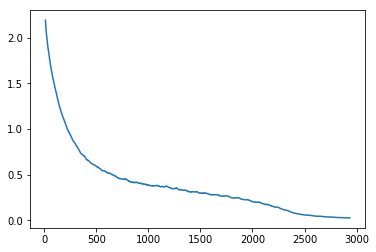

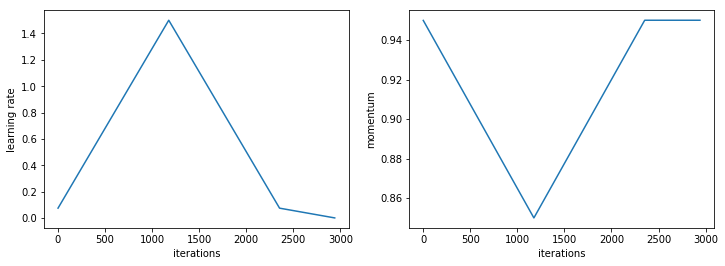

In [13]:
if args.warmup:
    learner.fit(args.lr/10, 1, cycle_len=1, wds=args.weight_decay,
            use_clr_beta=(100,1,0.9,0.8), loss_scale=args.loss_scale, **sargs)

learner.fit(args.lr,args.epochs, cycle_len=args.cycle_len,
            wds=args.weight_decay,
            use_clr_beta=args.use_clr, loss_scale=args.loss_scale,
            **sargs)
save_sched(learner.sched, args.save_dir)

In [15]:
learner.save('wrn_22_dawn_netblk_94')

In [15]:
learner.load('wrn_22_dawn_netblk_94')

### Let's fit another time so we can have a good comparison

epoch      trn_loss   val_loss   accuracy                   
    0      0.024694   0.201709   0.9417    
    1      0.026032   0.202267   0.9418                     
    2      0.02459    0.202201   0.9425                     
    3      0.024572   0.203718   0.9409                     
    4      0.023587   0.204155   0.9412                     
    5      0.024833   0.204028   0.9413                     
    6      0.022673   0.204859   0.9416                     
    7      0.022679   0.204319   0.9417                     
    8      0.022726   0.204558   0.9409                     
    9      0.023181   0.204918   0.9413                     



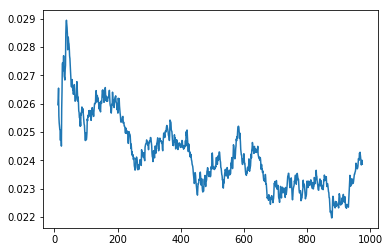

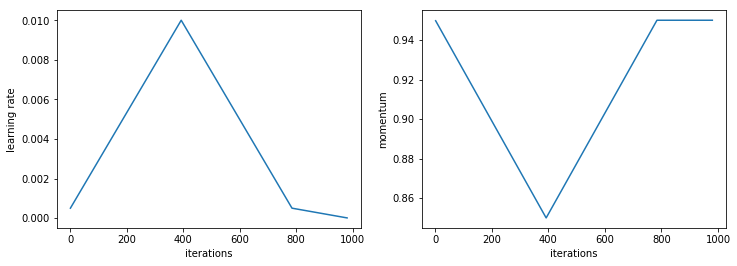

In [16]:
learner.fit(.01,args.epochs, cycle_len=10,
            wds=args.weight_decay,
            use_clr_beta=args.use_clr, loss_scale=args.loss_scale,
            **sargs)
save_sched(learner.sched, args.save_dir)

In [17]:
learner.save('wrn_22_dawn_netblk_94-samearch-epoch2')

### Loss seems to stagnate. Let's try lower lr 

In [22]:
learner.load('wrn_22_dawn_netblk_94')

 10%|█         | 10/98 [00:02<00:18,  4.83it/s, loss=0.0252]

Exception in thread Thread-66:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      0.025027   0.201463   0.9415    
    1      0.027213   0.202321   0.9414                     
    2      0.024938   0.201524   0.9419                     
    3      0.025795   0.201472   0.9423                     
    4      0.025591   0.203244   0.9417                     
    5      0.026017   0.201155   0.9419                     
    6      0.026661   0.201514   0.9417                     
    7      0.026315   0.203042   0.9412                     
    8      0.02512    0.202314   0.9412                     
    9      0.026203   0.202965   0.9414                     



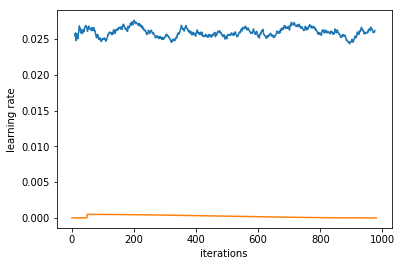

In [23]:
learner.fit(.0005,args.epochs, cycle_len=10,
            wds=args.weight_decay, loss_scale=args.loss_scale,
            **sargs)
save_sched(learner.sched, args.save_dir)

### One last time

In [22]:
learner.load('wrn_22_dawn_netblk_94')

epoch      trn_loss   val_loss   accuracy                   
    0      0.026116   0.20106    0.9423    
    1      0.025932   0.201233   0.9423                     
    2      0.024974   0.201628   0.9407                     
    3      0.025619   0.203512   0.9414                     
    4      0.026225   0.203159   0.9418                     
    5      0.026438   0.200673   0.9419                     
    6      0.024699   0.201114   0.9426                     
    7      0.02558    0.202239   0.9414                     
    8      0.02507    0.203346   0.9416                     
    9      0.024194   0.202236   0.9417                     



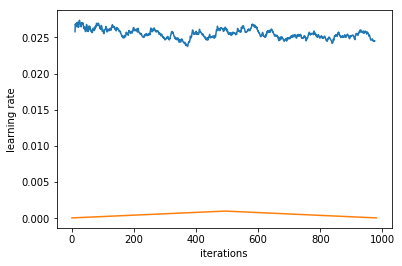

In [28]:
learner.fit(.001,args.epochs, cycle_len=10,
            wds=args.weight_decay, loss_scale=args.loss_scale, use_clr=(20,2),
            **sargs)
save_sched(learner.sched, args.save_dir)

### Ok now double size

In [18]:
learner.load('wrn_22_dawn_netblk_94')

In [16]:
m1 = learner.model

In [17]:
arch2 = 'wrn_28'
m2 = cifar10models.__dict__[arch2] if arch2 in cifar10_names else models.__dict__[arch2]
m2 = m2()

In [21]:
sd1, sd2 = m1.state_dict(), m2.state_dict()

In [22]:
sd2.update(sd1)

In [23]:
m2.load_state_dict(sd2)

In [24]:
new_params = set(sd2) - set(sd1); new_params

{'features.1.layer.3.bn.bias',
 'features.1.layer.3.bn.running_mean',
 'features.1.layer.3.bn.running_var',
 'features.1.layer.3.bn.weight',
 'features.1.layer.3.conv1.weight',
 'features.1.layer.3.conv2.0.bias',
 'features.1.layer.3.conv2.0.running_mean',
 'features.1.layer.3.conv2.0.running_var',
 'features.1.layer.3.conv2.0.weight',
 'features.1.layer.3.conv2.2.weight',
 'features.2.layer.3.bn.bias',
 'features.2.layer.3.bn.running_mean',
 'features.2.layer.3.bn.running_var',
 'features.2.layer.3.bn.weight',
 'features.2.layer.3.conv1.weight',
 'features.2.layer.3.conv2.0.bias',
 'features.2.layer.3.conv2.0.running_mean',
 'features.2.layer.3.conv2.0.running_var',
 'features.2.layer.3.conv2.0.weight',
 'features.2.layer.3.conv2.2.weight',
 'features.3.layer.3.bn.bias',
 'features.3.layer.3.bn.running_mean',
 'features.3.layer.3.bn.running_var',
 'features.3.layer.3.bn.weight',
 'features.3.layer.3.conv1.weight',
 'features.3.layer.3.conv2.0.bias',
 'features.3.layer.3.conv2.0.runnin

In [26]:
# a = 'sdfdsf'

In [ ]:
# a.endswith('bn.bias')

In [27]:
for k,v in m2.named_parameters():
    if k in sd1:
        v.required_grad=False
    if k in new_params and k.endswith('bn.bias'):
        print(v)
        v.data.zero_()

In [28]:
m2 = m2.cuda()

In [29]:
learner2 = Learner.from_model_data(m2, data)
learner2.crit = F.cross_entropy
learner2.metrics = [accuracy]
if args.fp16: learner2.half()

epoch      trn_loss   val_loss   accuracy                   
    0      0.042653   0.210187   0.9399    
    1      0.035342   0.20863    0.9405                     
    2      0.032633   0.209385   0.9407                     
    3      0.029704   0.210101   0.9406                     
    4      0.027098   0.211918   0.9421                     
    5      0.026394   0.21579    0.9412                     
    6      0.025734   0.217428   0.942                      
    7      0.024595   0.217304   0.9421                     
    8      0.024773   0.217709   0.9428                     
    9      0.023811   0.216756   0.9415                     



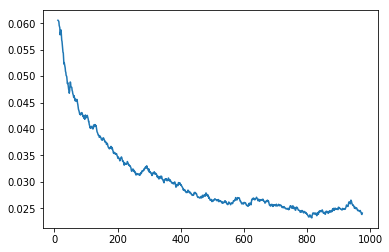

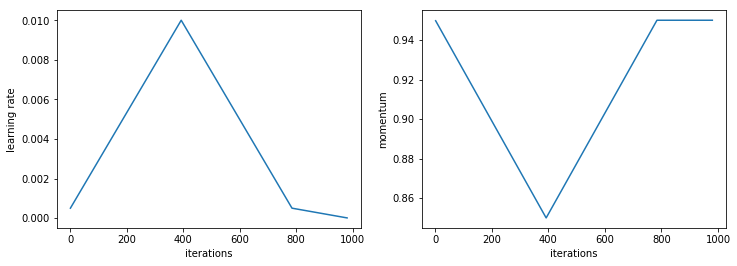

In [30]:
# Full size
update_model_dir(learner2, args.save_dir)
sargs = save_args('depth28', args.save_dir)

# learner2.fit(args.lr,args.epochs, cycle_len=args.cycle_len,
learner2.fit(1e-2,args.epochs, cycle_len=10,
            wds=args.weight_decay,
            use_clr_beta=args.use_clr, loss_scale=args.loss_scale,
            **sargs)
save_sched(learner2.sched, args.save_dir)